In [1]:
%matplotlib inline
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import random
import subprocess
import os

In [11]:
working_directory = "../../neet_spring_2019/"

# saved csv from car
driving_data = working_directory + "tests/tables/run_03_15_00_39/run_03_15_00_39.csv"

# directory location of car images
parent_dir   = working_directory + "tests/tables/run_03_15_00_39/"

# write imgs to folder
dest_img_dir = working_directory + "viz_tables/"

output_video_location = working_directory + "tables.mp4"

In [3]:
imgs = []
ngls = []

with open(driving_data) as fh:
    for line in fh:
        l = line.split(',')
        img = l[0]
        imgs.append(parent_dir + img)
        ngl = l[1]
        ngl = float(ngl)
        ngls.append(ngl)
        
print(len(imgs), len(ngls))

(3310, 3310)


In [6]:
def viz_angle(img, angle, ground_truth=None):
    height, width = img.shape[0], img.shape[1]
    bar_height_px = int(0.8 * height)
    bar_left_px   = int(0.2 * width)
    bar_right_px  = int(0.8 * width)
    
    # visualize bar
    cv.line(img, (bar_left_px, bar_height_px), (bar_right_px, bar_height_px), (0,255,0), thickness=8)
    
    # visualize center line
    bar_length_px      = bar_right_px - bar_left_px
    bar_half_length_px = int(bar_length_px / 2.)
    bar_center_px      = bar_half_length_px + bar_left_px
    centerline_hfht_px = 20
    cv.line(img, (bar_center_px, bar_height_px - centerline_hfht_px), 
            (bar_center_px, bar_height_px  + centerline_hfht_px),
            (0,0,0), thickness=2)

    # visualize angle
    # NOTE: positive servo angles turn left, negative-right. Here, flip the sign for visualization
    px_offset          = int(bar_half_length_px * angle) * -1
    loc                = (bar_center_px + px_offset, bar_height_px)
    cv.circle(img, loc, 4, (0,0,255), thickness=15)
    
    return img

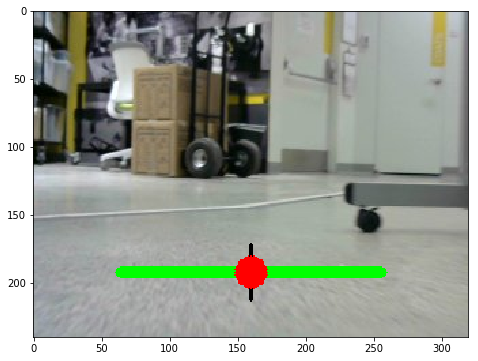

In [7]:
idx = random.randint(0,len(imgs)-1)

img = cv.imread(imgs[idx])
result= viz_angle(np.copy(img), ngls[idx])

fig,ax = plt.subplots()
ax.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
fig.set_size_inches(8,6)

In [ ]:
# write images with visualized angles
for idx, (imgfn, ngl) in enumerate(zip(imgs, ngls)):
    if idx % 300 == 0:
        print(idx)
    img = cv.imread(imgfn)
    viz = viz_angle(img, ngl)
    output_fn = dest_img_dir + "{:05d}.jpg".format(idx)
    cv.imwrite(output_fn, viz)

In [12]:
#save video: NOTE - this will overwrite an existing video
ffmpeg = """ffmpeg -y -framerate 30 -pattern_type glob -i '*.jpg' -c:v libx264 -profile:v high -crf 26 -pix_fmt yuv420p {}"""

curdir = os.getcwd()
try:
    video = ffmpeg.format(output_video_location)
    os.chdir(dest_img_dir)
    subprocess.call(video, shell=True)
finally:
    os.chdir(curdir)